In [14]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from tcn import TCN, tcn_full_summary

from model.data_parser import convert_jaad_dict_to_df, get_JAAD_data
#Load data
data_dir = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/JAAD_per_person/"

X, Y = convert_jaad_dict_to_df(get_JAAD_data(data_dir))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Starting to read JAAD json files!


# Random forest

In [13]:
from skmultilearn.problem_transform import ClassifierChain

from sklearn.ensemble import RandomForestClassifier

classifier = ClassifierChain(
        classifier=RandomForestClassifier(n_estimators=100),
        require_dense=[False, True]
    )

classifier.fit(X_train, Y_train)
# predict
predictions = classifier.predict(X_test)

print(accuracy_score(Y_test, predictions))

0.04928611760909898
0.8362507058159232


In [16]:
classifier.fit(X_train, Y_train)
predictions = classifier.predict(X_test)
df = pd.DataFrame.sparse.from_spmatrix(predictions)

0.04839880616278132
0.8384286520932483


TypeError: len() of unsized object

In [28]:
print(metrics.hamming_loss(Y_test, df))
print(metrics.accuracy_score(Y_test, df))
i=0
for col in df:
    df = df.rename(columns={col: str(int(col))})
for col in Y_test.columns:
    print(col + " accury:")
    print(metrics.accuracy_score(Y_test[col], df[str(i)]) )
    i += 1

0.04839880616278132
0.8384286520932483
look accury:
0.9244171977091232
action accury:
0.9409534564814068
cross accury:
0.8945712672420747
hand_gesture accury:
0.9983867064612406
nod accury:
0.9996773412922482


# LSTM

In [3]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_lstm_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [4]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.6, name='f1_score', dtype=None), 'accuracy'])

model.fit(X_train, Y_train, epochs=11, batch_size=32, callbacks=[cp_callback])

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2331 - f1_score: 0.7554 - accuracy: 0.7403
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3092/3092 [==============================] - 59s 17ms/step - loss: 0.2331 - f1_score: 0.7555 - accuracy: 0.7403
Epoch 2/11
3090/3092 [============================>.] - ETA: 0s - loss: 0.2294 - f1_score: 0.7575 - accuracy: 0.7407
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_06.ckpt
3092/3092 [==============================] - 53s 17ms/step - loss: 0.2294 - f1_score: 0.7575 - accuracy: 0.7407
Epoch 3/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2282 - f1_score: 0.7574 - accuracy: 0.7406
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/save

Accuracy: 0.8266213812065341


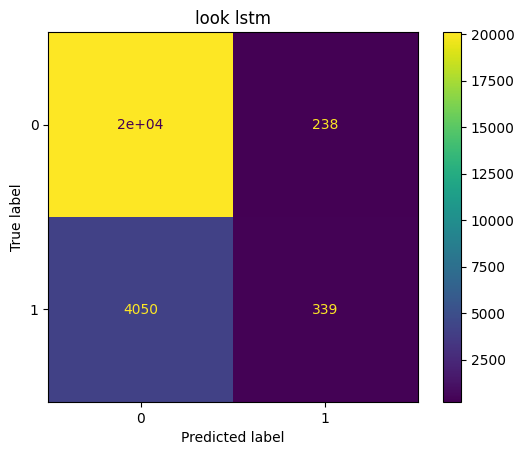

Accuracy: 0.8546417596635937


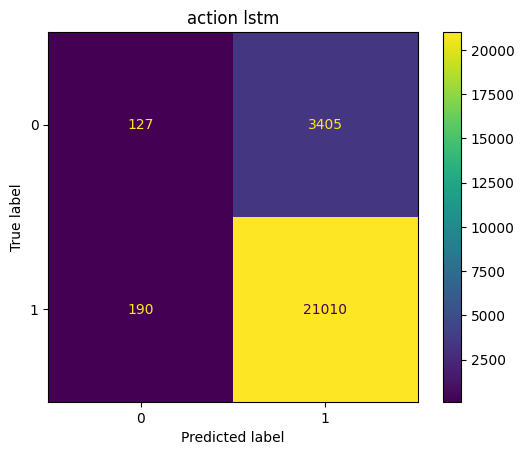

Accuracy: 0.9969270580624292


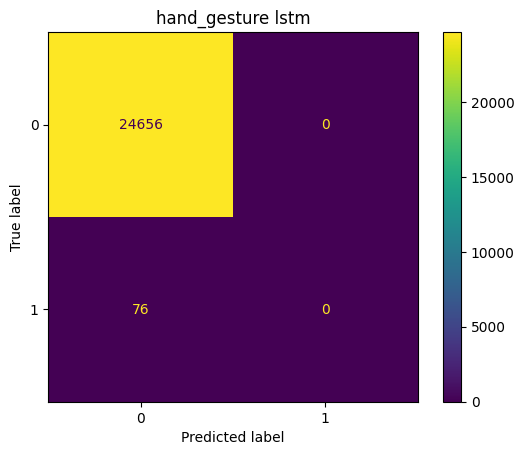

Accuracy: 0.9992317645156074


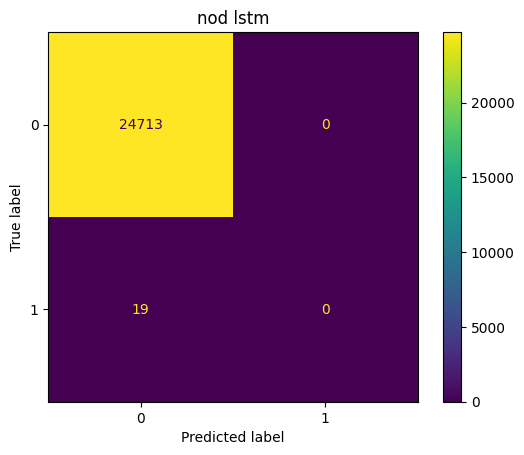

In [5]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.6 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix((Y_test.to_numpy())[:, i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' lstm')
    plt.show()
    i += 1

In [6]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_lstm_05_{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [7]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='sigmoid'))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.5, name='f1_score', dtype=None)])

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(X_train, Y_train, epochs=11, batch_size=32, callbacks=[cp_callback])

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2326 - f1_score: 0.7601
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0001.ckpt
3092/3092 [==============================] - 61s 17ms/step - loss: 0.2326 - f1_score: 0.7601
Epoch 2/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2295 - f1_score: 0.7575
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0002.ckpt
3092/3092 [==============================] - 53s 17ms/step - loss: 0.2295 - f1_score: 0.7575
Epoch 3/11
3091/3092 [============================>.] - ETA: 0s - loss: 0.2292 - f1_score: 0.7575
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_lstm_05_0003.ckpt
3092/3092 [==============================] - 55s 18m

Accuracy: 0.8269044153323629


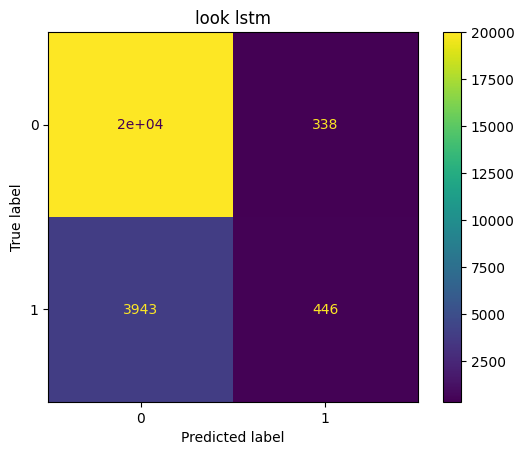

Accuracy: 0.8572699336891476


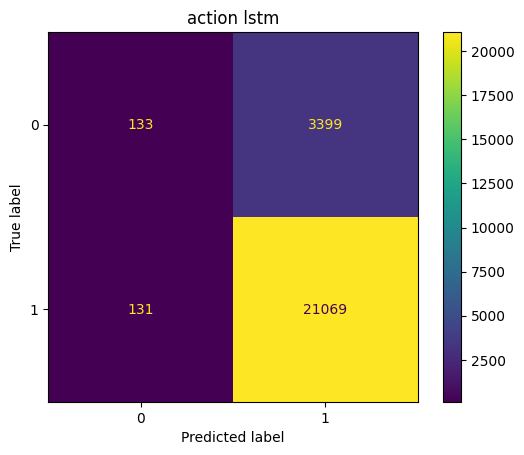

Accuracy: 0.9969270580624292


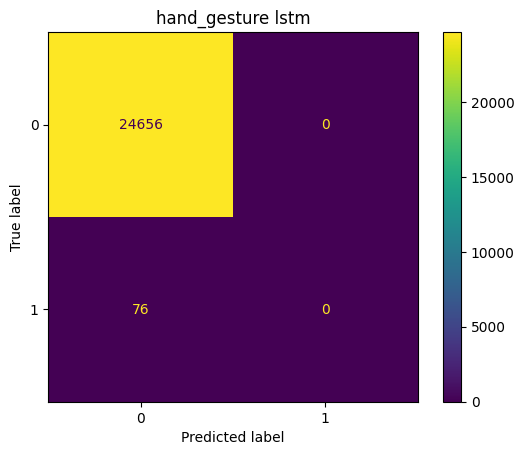

Accuracy: 0.9992317645156074


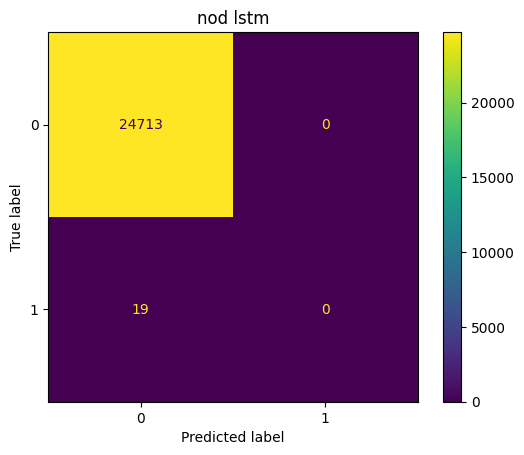

In [8]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' lstm')
    plt.show()
    i += 1

# TCN

In [3]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings//cp_tcn_lstm_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [4]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/8
 999/1000 [============================>.] - ETA: 0s - loss: 0.2139 - f1_score: 0.7572
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_06.ckpt
1000/1000 [==============================] - 152s 145ms/step - loss: 0.2139 - f1_score: 0.7572
Epoch 2/8
 999/1000 [============================>.] - ETA: 0s - loss: 0.2050 - f1_score: 0.7579
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_06.ckpt
1000/1000 [==============================] - 148s 148ms/step - loss: 0.2050 - f1_score: 0.7579
Epoch 3/8
 999/1000 [============================>.] - ETA: 0s - loss: 0.1999 - f1_score: 0.7648
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_rec

Accuracy: 0.8279556849425845


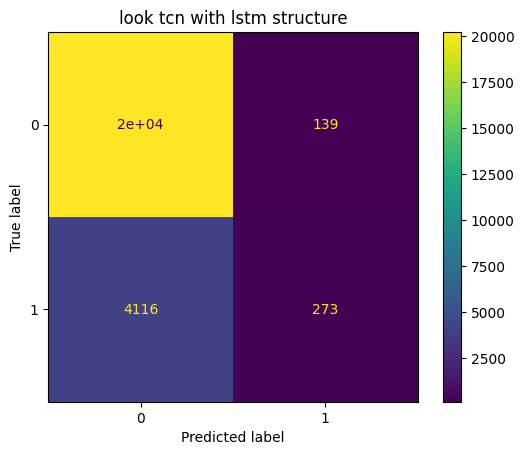

Accuracy: 0.8649118550865276


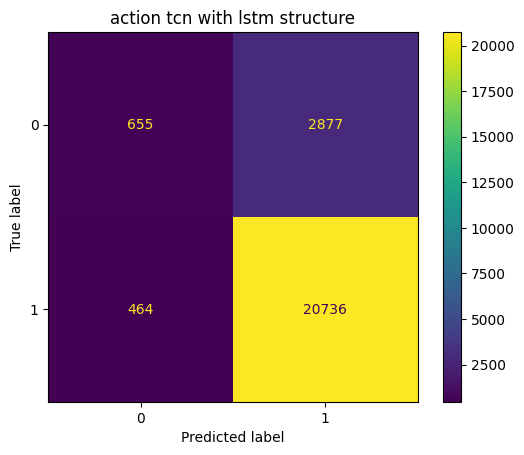

Accuracy: 0.9969270580624292


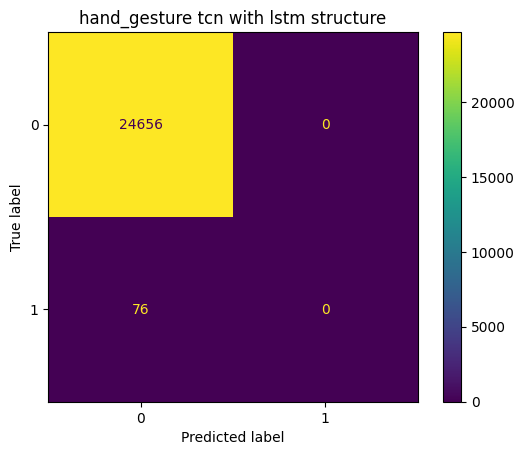

Accuracy: 0.9992317645156074


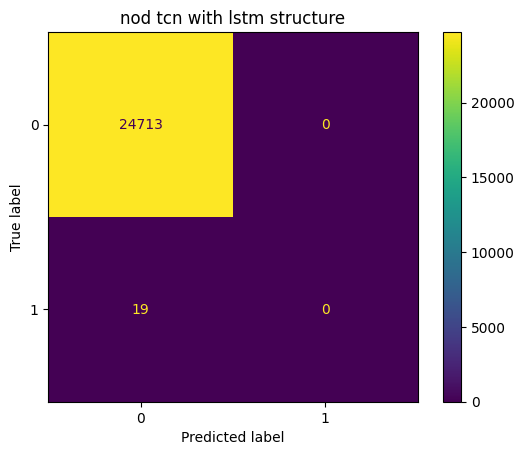

In [5]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.6 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn with lstm structure')
    plt.show()
    i += 1

In [6]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_lstm_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [7]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.5, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/8
 999/1000 [============================>.] - ETA: 0s - loss: 0.2135 - f1_score: 0.7589
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_05.ckpt
1000/1000 [==============================] - 155s 147ms/step - loss: 0.2135 - f1_score: 0.7589
Epoch 2/8
1000/1000 [==============================] - ETA: 0s - loss: 0.2048 - f1_score: 0.7656
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_lstm_05.ckpt
1000/1000 [==============================] - 152s 152ms/step - loss: 0.2048 - f1_score: 0.7656
Epoch 3/8
 999/1000 [============================>.] - ETA: 0s - loss: 0.2006 - f1_score: 0.7790
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_rec

Accuracy: 0.831432961345625


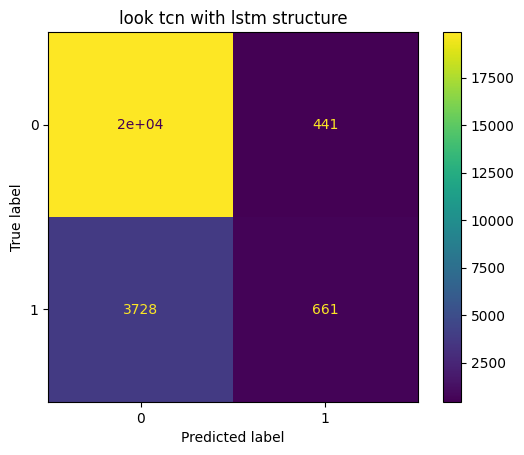

Accuracy: 0.8664887595018599


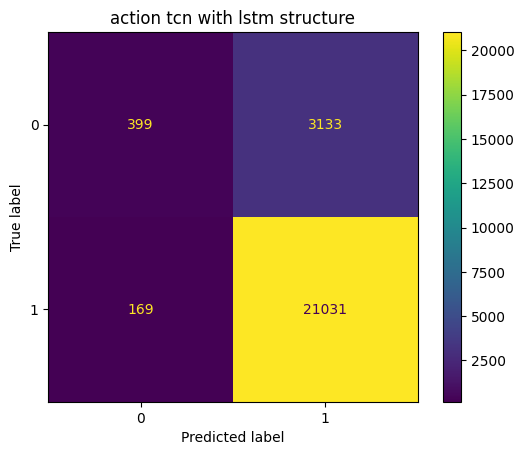

Accuracy: 0.9969270580624292


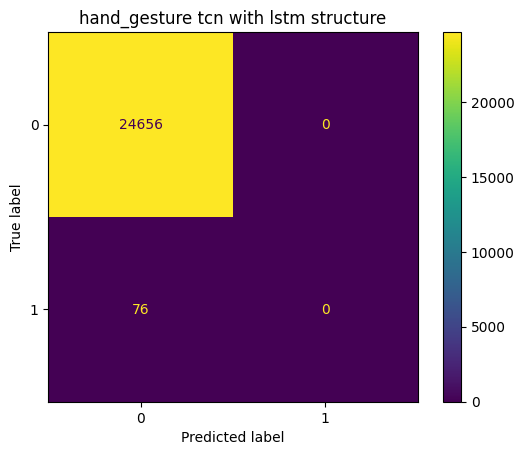

Accuracy: 0.9992317645156074


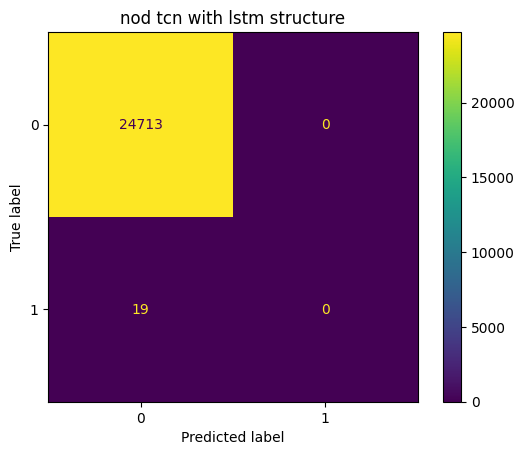

In [8]:
i = 0
for col in Y_train.columns:

    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn with lstm structure')
    plt.show()
    i += 1

In [3]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_06.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [5]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

history = m.fit(X_train, Y_train,  epochs=10, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.2209 - f1_score: 0.7561
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_05.ckpt
1000/1000 [==============================] - 162s 153ms/step - loss: 0.2209 - f1_score: 0.7561
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.2062 - f1_score: 0.7574
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_05.ckpt
1000/1000 [==============================] - 150s 150ms/step - loss: 0.2062 - f1_score: 0.7575
Epoch 3/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.2030 - f1_score: 0.7594
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognitio

Accuracy: 0.8326459647420346


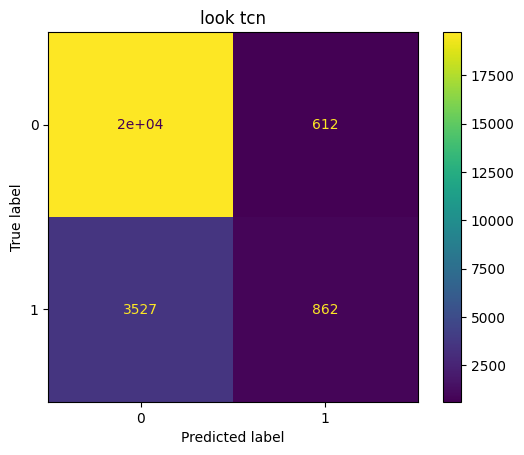

Accuracy: 0.8694808345463367


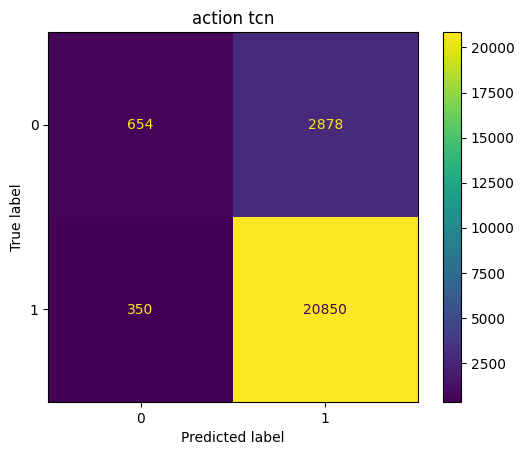

Accuracy: 0.9970483584020702


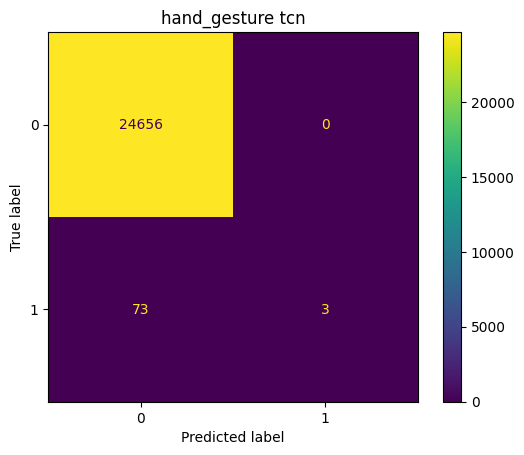

Accuracy: 0.9992317645156074


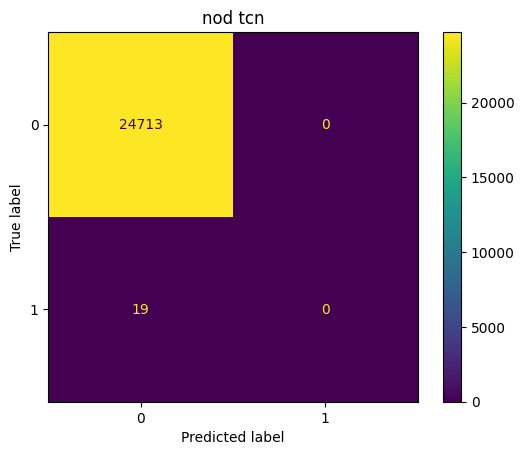

In [6]:
i = 0
for col in Y_train.columns:
    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn')
    plt.show()
    i += 1

In [7]:
checkpoint_path = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings/cp_tcn_05.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [8]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(4, activation='sigmoid')
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.6, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

history = m.fit(X_train, Y_train,  epochs=10, steps_per_epoch=1000, callbacks=[cp_callback])
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.2226 - f1_score: 0.7557
Epoch 1: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_05.ckpt
1000/1000 [==============================] - 156s 149ms/step - loss: 0.2226 - f1_score: 0.7557
Epoch 2/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.2070 - f1_score: 0.7582
Epoch 2: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognition/saved_trainings\cp_tcn_05.ckpt
1000/1000 [==============================] - 162s 162ms/step - loss: 0.2070 - f1_score: 0.7582
Epoch 3/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.2031 - f1_score: 0.7612
Epoch 3: saving model to C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/model/action_recognitio

Accuracy: 0.8321203299369239


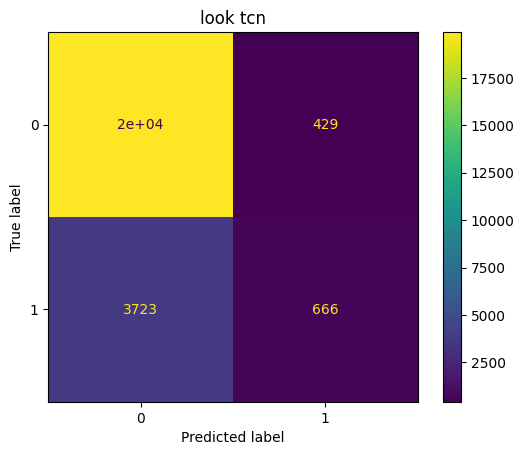

Accuracy: 0.8655183567847323


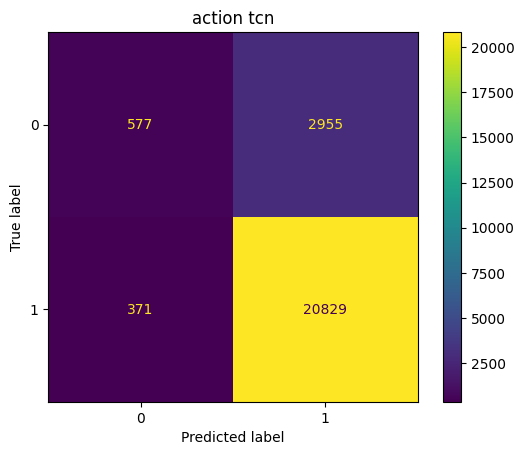

Accuracy: 0.9970079249555233


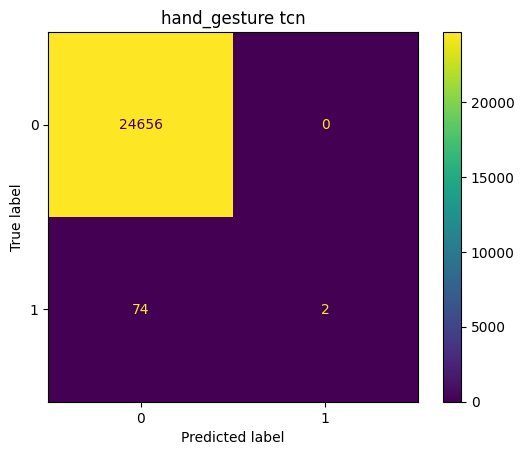

Accuracy: 0.9992317645156074


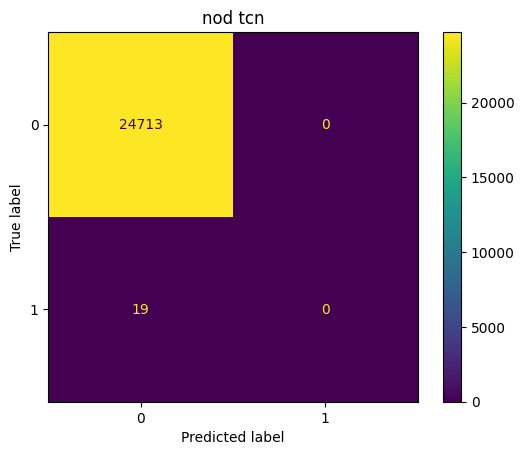

In [9]:
i = 0
for col in Y_train.columns:
    pred = [1 if x >= 0.5 else 0 for x in (predictions[:, i])]
    test = (Y_test.to_numpy())[:, i]
    print(f'Accuracy: {accuracy_score(test,pred)}')
    cm = confusion_matrix(test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(col + ' tcn')
    plt.show()
    i += 1

In [17]:
for col in Y.columns:
    print(col)
    print(Y[col].count())
    print(Y[col].sum())
    print((Y[col].sum() / Y[col].count()) * 100)

look
123656
22337.0
18.0638222164715
action
123656
105754.0
85.52274050591964
hand_gesture
123656
369.0
0.29840848806366044
nod
123656
109.0
0.08814776476677233
